In [1]:
!git clone https://github.com/bessszilard/Self-Driving-Car-Simulator-Data

fatal: destination path 'Self-Driving-Car-Simulator-Data' already exists and is not an empty directory.


In [2]:
!ls
!ls Self-Driving-Car-Simulator-Data

model.h5  sample_data  Self-Driving-Car-Simulator-Data
driving_log.csv  IMG  LICENSE  README.md


In [3]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPool2D, Dropout, Flatten, Dense, Lambda
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
from google.colab import files

Using TensorFlow backend.


In [0]:
# lines = []
# with open("../data/driving_log.csv") as csvfile:
#     reader = csv.reader(csvfile)
#     for line in reader:
#         lines.appedn

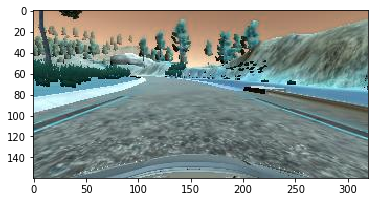

In [10]:
# datadir = 'Self-Driving-Car-Simulator-Data'
# colums = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
# data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = colums)
# pd.set_option('display.max_colwidth', -1)
# data.head()

lines = []
with open('Self-Driving-Car-Simulator-Data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
images = []
measurements = []

for line in lines:
    source_path = line[0]
    filename = source_path.split('\\')[-1]
    current_path = 'Self-Driving-Car-Simulator-Data/IMG/' + filename
    image = cv2.imread(current_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)
    
augmented_images, augemented_measurements = [], []    
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augemented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image, 1))
    augemented_measurements.append(-measurement)
    
plt.imshow(images[100])

In [11]:
X_train = np.array(augmented_images)
y_train = np.array(augemented_measurements)

model = Sequential()
model.add(Lambda(lambda x: ((x / 255.0) - 0.5), input_shape=(160, 320, 3)))
model.add(Convolution2D(6, 5, 5, activation='relu'))
model.add(MaxPool2D())
model.add(Convolution2D(6, 5, 5, activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=7)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (5, 5), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (5, 5), activation="relu")`
  


Train on 11465 samples, validate on 2867 samples
Epoch 1/7
11465/11465 [==============================] - 12s 1ms/step - loss: 1.7268 - val_loss: 0.0089
Epoch 2/7
11465/11465 [==============================] - 11s 960us/step - loss: 0.0124 - val_loss: 0.0079
Epoch 3/7
11465/11465 [==============================] - 11s 966us/step - loss: 0.0109 - val_loss: 0.0068
Epoch 4/7
11465/11465 [==============================] - 11s 962us/step - loss: 0.0092 - val_loss: 0.0056
Epoch 5/7
11465/11465 [==============================] - 11s 957us/step - loss: 0.0076 - val_loss: 0.0049
Epoch 6/7
11465/11465 [==============================] - 11s 945us/step - loss: 0.0065 - val_loss: 0.0048
Epoch 7/7
11465/11465 [==============================] - 11s 983us/step - loss: 0.0057 - val_loss: 0.0050


In [0]:
model.save('model.h5')
# !ls
files.download('model.h5')